<a href="https://colab.research.google.com/github/KyungRyeolBaek/study/blob/main/AI%20study/%EC%B9%98%EC%95%84/tooth_CNN_210815.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tooth_CNN

In [7]:
import tensorflow as tf
# Ture가 나와야 GPU가 작동 되는 중 !
from tensorflow.python.client import device_lib 
device_lib.list_local_devices() 
tf.test.is_gpu_available()

True

(256, 380)

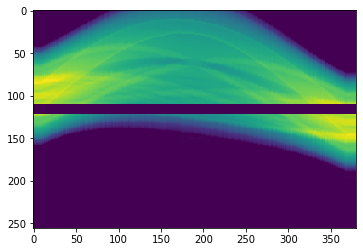

In [47]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras import datasets, layers, models

### 마스크, metal_line, padding, y_shape 설정 ----------------------------------
df_line = pd.read_table('./images/sino_examples/metal_point2.txt', sep = ',', header = None)
df = pd.read_table('./images/sino_examples/sino_wmetal.txt', sep = ',', header = None)

mask_list = []

for i in range(360):
  temp = []
  for i, k in zip(df.iloc[:, i]== 200, df.iloc[:, i].index):
    if i == True:
      temp.append(k)
  mask_list.append(temp)

y_shape = 0
padding = 0
metal_line = []
count = 0
for i in mask_list[:]:
  mid = int((max(i) - min(i))/2)

  if mid > padding:
    padding = mid

  if (max(i)-min(i)) % 2 == 0:
    metal_line.append(min(i) + mid)

  else:
    metal_line.append(min(i) + mid + 1)

  count += 1
metal_shift = [i - min(metal_line) for i in metal_line]
### ----------------------------------------------------------------

# parameter
image_num = [0, 1, 2, 3, 4, 5, 6, 7, 8]       # 전체 이미지
train_image_num = [1, 2, 3, 4, 5, 6, 7, 8]    # 트레이닝 이미지 범위 [1, 2, 3, 4, 5, 6, 7, 8]
# test_image_num = 0                            # 테스트 이미지 숫자 [0]
X_shape = [20, 21]                            # X 형태 [행, 열] -> 트레이닝 크기
# y_shape = 5                                   # y 형태 -> 트레이닝 결과 크기
# y_test_range = [100, 110]                     # y_test 예측 범위 [100 ~ 110]
epoch = 10                                  # epoch 횟수

# 데이터 전처리
for i, j, k in zip(df.columns, metal_shift, metal_line):
      df.iloc[k - 1 - padding : k + padding + 1, i] = 200
      df[i] = df[i].shift(-j, fill_value = 0)
    
y_test_range = [min(df[df.iloc[:, 0] == 200].index), max(df[df.iloc[:, 0] == 200].index) + 1]
y_shape = y_test_range[1] - y_test_range[0]

df.iloc[y_test_range[0] : y_test_range[1], :] = 0
df = df / math.ceil(df.max().max())

df_temp_left = pd.DataFrame()
df_temp_right = pd.DataFrame()
for i in range(int(X_shape[1]/2)):
    df_temp_left[i] = df[0]
    df_temp_right[i] = df[359]

df_left = pd.concat([df_temp_left, df], axis = 1)
df = pd.concat([df_left, df_temp_right], axis = 1)

plt.imshow(df)

df.shape

In [52]:
# 이미지 양쪽 열 10개씩 늘림.
for num in image_num: 
    globals()['df{}'.format(num)] = pd.read_table('./images/sino_examples/sino_{}.txt'.format(num),sep=',', header = None)
    for i, j in zip(globals()['df{}'.format(num)].columns, metal_shift):
      globals()['df{}'.format(num)][i] = globals()['df{}'.format(num)][i].shift(-j, fill_value = 0)
    globals()['df{}'.format(num)] = globals()['df{}'.format(num)] / math.ceil(globals()['df{}'.format(num)].max().max())


for num in image_num:
    df_temp_left = pd.DataFrame()
    df_temp_right = pd.DataFrame()
    for i in range(int(X_shape[1]/2)):
        df_temp_left[i] = globals()['df{}'.format(num)][0]
        df_temp_right[i] = globals()['df{}'.format(num)][359]

    df_left = pd.concat([df_temp_left, globals()['df{}'.format(num)]], axis = 1)
    globals()['df{}'.format(num)] = pd.concat([df_left, df_temp_right], axis = 1)
    
# train셋, test셋으로 나누어 줍니다. X는 입력 변수, y는 출력 변수
X_train_org, X_test_org, y_train_org, y_test_org = [], [], [], []

# X 형태 (x_shape[0]/2 + x_shape[0]/2, x_shape[1]), y 형태 (y_shape)
for num in train_image_num:
    for i in range(globals()['df{}'.format(num)].shape[1] - X_shape[1]):                             # i, 열, 1
        for j in range(globals()['df{}'.format(num)].shape[0] - X_shape[0] - y_shape):                # j, 행, 0
            X_train_org.append(pd.concat([globals()['df{}'.format(num)].iloc[j:j+int(X_shape[0]/2), 0+i:X_shape[1]+i], globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2)+y_shape:j+int(X_shape[0]/2)+y_shape+int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))           # 아래
            if X_shape[1] % 2 == 0:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)])
            else:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)+1])

for i in range(df.shape[1] - X_shape[1]):
    X_test_org.append(pd.concat([df.iloc[y_test_range[0] - int(X_shape[0]/2):y_test_range[0], 0+i:X_shape[1]+i], df.iloc[y_test_range[1]:y_test_range[1] + int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))
    if X_shape[1] % 2 == 0:
        y_test_org.append(df.iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)])
    else:
        y_test_org.append(df.iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)+1])

X_train_org, X_test_org, y_train_org, y_test_org = np.array(X_train_org), np.array(X_test_org), np.array(y_train_org), np.array(y_test_org)

# RGB 값을 추가 합니다. 우선 흑백으로 설정 하였습니다.
# train 형태 : ((8*354*245, x_shape[0], x_shape[1], 1)), test 형태 : ((354, x_shape[0], x_shape[1], 1))
# tensorflow는 3차원만 지원하므로 3차원 형태로 reshape 해줘야 합니다.
X_train = X_train_org.reshape((len(train_image_num)*(df.shape[1]-X_shape[1])*(df.shape[0]-X_shape[0]-y_shape), X_shape[0], X_shape[1], 1))
X_test = X_test_org.reshape(((df.shape[1]-X_shape[1]), X_shape[0], X_shape[1], 1))
y_train = y_train_org
y_test = y_test_org

In [53]:
# model 생성
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_shape[0], X_shape[1], 1)))
# MaxPooling2D(filter)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(y_shape))
model.summary()

# model 구성
model.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 18, 19, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

Epoch 1/10
20104/20104 [==============================] - 85s 4ms/step - loss: 2.9718e-04 - accuracy: 0.4224
Epoch 2/10
20104/20104 [==============================] - 82s 4ms/step - loss: 2.9228e-04 - accuracy: 0.4212
Epoch 3/10
20104/20104 [==============================] - 84s 4ms/step - loss: 2.8645e-04 - accuracy: 0.4240
Epoch 4/10
20104/20104 [==============================] - 82s 4ms/step - loss: 2.8453e-04 - accuracy: 0.4181
Epoch 5/10
20104/20104 [==============================] - 57s 3ms/step - loss: 2.7912e-04 - accuracy: 0.4199
Epoch 6/10
20104/20104 [==============================] - 64s 3ms/step - loss: 2.7303e-04 - accuracy: 0.4211
Epoch 7/10
20104/20104 [==============================] - 52s 3ms/step - loss: 2.6912e-04 - accuracy: 0.4158
Epoch 8/10
20104/20104 [==============================] - 56s 3ms/step - loss: 2.6789e-04 - accuracy: 0.4185
Epoch 9/10
20104/20104 [==============================] - 57s 3ms/step - loss: 2.6679e-04 - accuracy: 0.4174
Epoch 10/10
20104/2

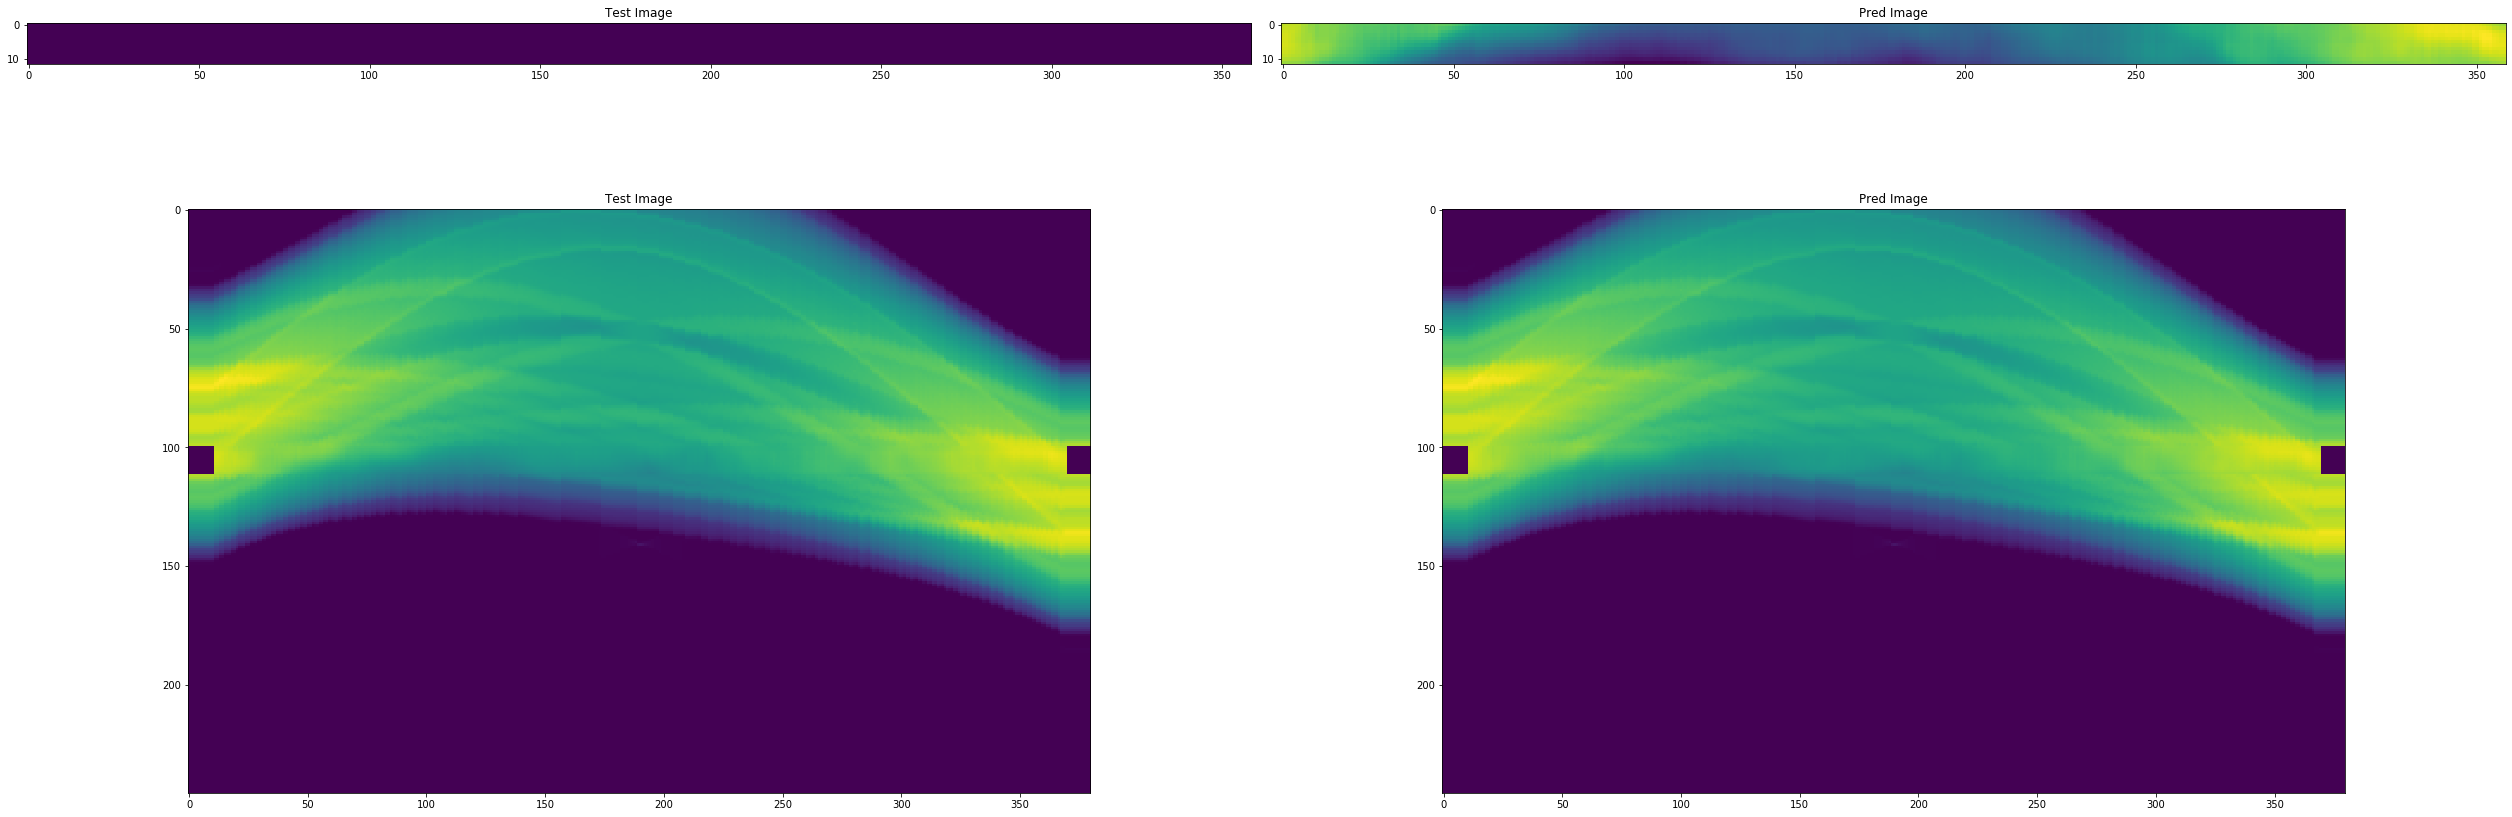

In [55]:
model.fit(X_train, y_train, epochs=epoch, verbose = 1)

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc
print(test_acc)   # 정확도

# 모델 예측
pred = model.predict(X_test)    # 예측 데이터를 ()안에 넣으면 됩니다.

figure, axes = plt.subplots(nrows=2, ncols=2, figsize = (35, 15))
axes[0][0].set_title('Test Image')
axes[0][0].imshow(y_test_org.T)
axes[0][1].set_title('Pred Image')
axes[0][1].imshow(pred.T)
axes[1][0].set_title('Test Image')
axes[1][0].imshow(df)
df_test_img = df
if X_shape[1] % 2 == 0:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):df.shape[1]-int(X_shape[1]/2)] = pred.T
else:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2)+1:df.shape[1]-int(X_shape[1]/2)] = pred.T
axes[1][1].set_title('Pred Image')
axes[1][1].imshow(df_test_img)
figure.colorbar;

figure.tight_layout()
plt.show()

# 예측 범위가 넓어서 그런지 예측 값이 별로 좋지 않네요...

이전 예측 범위는 5 -> 현재 예측 범위가 11

파라미터들을 수정해서 모델을 고치거나, 예측 범위를 줄여야 할것 같아요 !

In [58]:
# 주신 line이랑 제가 따로 중심부분만 딴 부분이랑 중간 중간 몇군데씩 안맞는 부분 있어서 제가 따로 딴 line을 사용 했습니다.
df_line == [i - min(metal_line) for i in metal_line]

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,True,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [ ]:
# mat 저장
import scipy.io as sio
# sio.savemat('df_test_img.mat', {'values' : df_test_img.values})